In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
sns.set(style="whitegrid")

DATA_PROCESSED = Path("../data/processed")
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# for importing src/ modules if needed later
import sys, os
ROOT = os.path.abspath("../") 
sys.path.append(ROOT)

In [3]:
# load basket-level transactions (one row per BasketID, a list of products)
transactions = pd.read_parquet(DATA_PROCESSED / "transactions.parquet")

# load association rules
rules = pd.read_parquet(DATA_PROCESSED / "association_rules.parquet")

# load line-level clean dataset to derive typical prices per product
df = pd.read_parquet(DATA_PROCESSED / "df_clean.parquet")

In [4]:
# string -> set helpers
def str_to_set(s: str) -> set:
    return set(x.strip().lower() for x in s.split(","))

rules["antecedents_set"] = rules["antecedents_str"].apply(str_to_set)
rules["consequents_set"] = rules["consequents_str"].apply(str_to_set)

# build typical product price (median) from df
price_per_product = (
    df.groupby("Product")["Price"]
      .median()
      .to_dict()
)

# ensure we look up prices in lowercase consistently
price_per_product_lc = {k.lower(): v for k, v in price_per_product.items()}

In [5]:
def recommend_products(basket, rules_df, top_n=3):
    """
    basket: list[str] user’s current products (any case)
    rules_df: association rules with 'antecedents_set', 'consequents_set', 'confidence', 'lift'
    returns: list[str] (lowercased product names), ordered by rule confidence
    """
    # normalise input to lowercase
    basket_set = set(p.strip().lower() for p in basket)

    # match rules: antecedent ⊆ basket
    matched = rules_df[rules_df["antecedents_set"].apply(lambda a: a.issubset(basket_set))]
    if matched.empty:
        return []

    matched = matched.sort_values(["confidence", "lift"], ascending=False)

    # flatten consequents in this order; dedupe; exclude items already owned
    recs = []
    for cset in matched["consequents_set"]:
        recs.extend(list(cset))
    recs = [r for r in recs if r not in basket_set]
    recs_unique = list(dict.fromkeys(recs))
    return recs_unique[:top_n]

In [6]:
def acceptance_probability(confidence: float, lift: float,
                           base=0.05, alpha=0.60, beta=0.20, p_max=0.60) -> float:
    p = base + alpha * confidence + beta * max(lift - 1.0, 0.0)
    return float(np.clip(p, 0.0, p_max))

In [7]:
def recommend_with_scores(basket, rules_df, top_n=3):
    """
    Returns: list of tuples [(item, best_conf_for_item, best_lift_for_item), ...]
    """
    basket_set = set(p.strip().lower() for p in basket)
    matched = rules_df[rules_df["antecedents_set"].apply(lambda a: a.issubset(basket_set))]
    if matched.empty:
        return []

    # for each consequent item, keep the best (max) confidence & lift seen
    best = {}
    for _, row in matched.iterrows():
        for item in row["consequents_set"]:
            if item in basket_set:
                continue
            if item not in best:
                best[item] = (row["confidence"], row["lift"])
            else:
                # keep the better rule (by confidence; tie-break by lift)
                c0, l0 = best[item]
                if (row["confidence"] > c0) or (row["confidence"] == c0 and row["lift"] > l0):
                    best[item] = (row["confidence"], row["lift"])

    # order by confidence then lift
    ordered = sorted(best.items(), key=lambda kv: (kv[1][0], kv[1][1]), reverse=True)
    top = ordered[:top_n]
    return [(item, conf, lift) for item, (conf, lift) in top]

In [8]:
def basket_revenue(products, price_map):
    """
    products: list[str] lower/any case
    price_map: dict[str->float] with lowercase keys
    returns: float revenue (sum of typical prices for unique items)
    """
    uniq = set(p.strip().lower() for p in products)
    return float(sum(price_map.get(p, 0.0) for p in uniq))

In [9]:
def simulate_ab_test(transactions_df,
                     rules_df,
                     price_map,
                     N=5000,
                     top_k=3,
                     seed=42,
                     base=0.05, alpha=0.60, beta=0.20, p_max=0.60):
    """
    Returns:
      results_df: per-session results with columns
        ['group','basket_size_pre','basket_size_post','rev_pre','rev_post',
         'accepted_n','accepted_items','seed_basket','recs_offered']
      summary: dict with aggregated KPIs
    """
    rng = np.random.default_rng(seed)
    random.seed(seed)

    # sample N baskets with replacement from real data
    sampled = transactions_df.sample(n=N, replace=True, random_state=seed)["products"].tolist()

    records = []
    for i, original_basket in enumerate(sampled):
        # normalise to lowercase
        base_basket = [p.strip().lower() for p in original_basket if isinstance(p, str) and p.strip()]
        if not base_basket:
            # skip empty; generate a 1-item fallback (rare)
            continue

        # assign group
        group = "treatment" if (i % 2 == 0) else "control"

        # pre metrics
        rev_pre = basket_revenue(base_basket, price_map)
        size_pre = len(set(base_basket))

        if group == "control":
            rev_post = rev_pre
            size_post = size_pre
            accepted_n = 0
            accepted_items = []
            recs_offered = []
        else:
            # treatment flow
            # get top-k recs with best scores
            recs = recommend_with_scores(base_basket, rules_df, top_n=top_k)
            recs_offered = [r[0] for r in recs]

            accepted_items = []
            for item, conf, lift in recs:
                p = acceptance_probability(conf, lift, base=base, alpha=alpha, beta=beta, p_max=p_max)
                # Bernoulli trial
                if rng.random() < p:
                    accepted_items.append(item)

            # post-basket
            post_basket = list(set(base_basket) | set(accepted_items))
            rev_post = basket_revenue(post_basket, price_map)
            size_post = len(post_basket)
            accepted_n = len(accepted_items)

        records.append({
            "group": group,
            "basket_size_pre": size_pre,
            "basket_size_post": size_post,
            "rev_pre": rev_pre,
            "rev_post": rev_post,
            "uplift_abs": rev_post - rev_pre,
            "uplift_pct": (rev_post - rev_pre) / rev_pre if rev_pre > 0 else np.nan,
            "accepted_n": accepted_n,
            "accepted_items": accepted_items,
            "seed_basket": base_basket,
            "recs_offered": recs_offered
        })

    results_df = pd.DataFrame(records)

    # aggregate KPIs
    ctrl = results_df[results_df["group"] == "control"]
    trt  = results_df[results_df["group"] == "treatment"]

    summary = {
        "N": len(results_df),
        "N_control": len(ctrl),
        "N_treatment": len(trt),
        "avg_rev_control": ctrl["rev_post"].mean(),
        "avg_rev_treatment": trt["rev_post"].mean(),
        "avg_rev_uplift_abs": trt["rev_post"].mean() - ctrl["rev_post"].mean(),
        "avg_rev_uplift_pct": (trt["rev_post"].mean() / ctrl["rev_post"].mean() - 1.0) if ctrl["rev_post"].mean() > 0 else np.nan,
        "avg_basket_size_control": ctrl["basket_size_post"].mean(),
        "avg_basket_size_treatment": trt["basket_size_post"].mean(),
        "avg_size_uplift": trt["basket_size_post"].mean() - ctrl["basket_size_post"].mean(),
        "accept_rate_treatment": (trt["accepted_n"] > 0).mean() if len(trt) else np.nan,
        "mean_accepted_items_treatment": trt["accepted_n"].mean() if len(trt) else np.nan
    }

    return results_df, summary

In [10]:
results, summary = simulate_ab_test(
    transactions_df=transactions,
    rules_df=rules,
    price_map=price_per_product_lc,
    N=5000,      # adjust if too slow
    top_k=3,
    seed=42
)

summary

{'N': 5000,
 'N_control': 2500,
 'N_treatment': 2500,
 'avg_rev_control': 63.788090800000006,
 'avg_rev_treatment': 66.81631999999999,
 'avg_rev_uplift_abs': 3.028229199999984,
 'avg_rev_uplift_pct': 0.04747326910119698,
 'avg_basket_size_control': 20.82,
 'avg_basket_size_treatment': 22.4444,
 'avg_size_uplift': 1.6244000000000014,
 'accept_rate_treatment': 0.838,
 'mean_accepted_items_treatment': 1.5756}

In [11]:
ctrl_rev = results.loc[results.group=="control", "rev_post"].values
trt_rev  = results.loc[results.group=="treatment","rev_post"].values
t_stat, p_value = stats.ttest_ind(trt_rev, ctrl_rev, equal_var=False)
t_stat, p_value

(1.6729647486461978, 0.09439688868383808)

In [12]:
def bootstrap_ci_diff(a, b, n_boot=2000, seed=42, ci=0.95):
    rng = np.random.default_rng(seed)
    diffs = []
    n_a, n_b = len(a), len(b)
    for _ in range(n_boot):
        sa = rng.choice(a, size=n_a, replace=True)
        sb = rng.choice(b, size=n_b, replace=True)
        diffs.append(sa.mean() - sb.mean())
    lo = np.percentile(diffs, (1-ci)*50)
    hi = np.percentile(diffs, 100 - (1-ci)*50)
    return float(lo), float(hi)

ci_lo, ci_hi = bootstrap_ci_diff(trt_rev, ctrl_rev, n_boot=3000)
ci_lo, ci_hi

(-0.37697212000000396, 6.604429610000015)

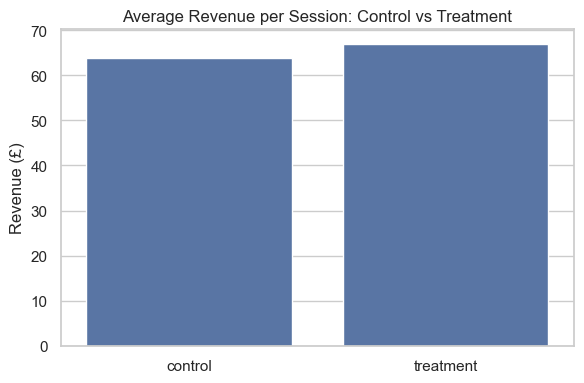

In [13]:
group_means = results.groupby("group")["rev_post"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=group_means, x="group", y="rev_post")
plt.title("Average Revenue per Session: Control vs Treatment")
plt.xlabel("")
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.savefig(FIG_DIR / "abtest_avg_revenue.png")
plt.show()

/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_17015/3472645994.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ctrl_rev, label="Control", shade=True)
/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_17015/3472645994.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trt_rev,  label="Treatment", shade=True)


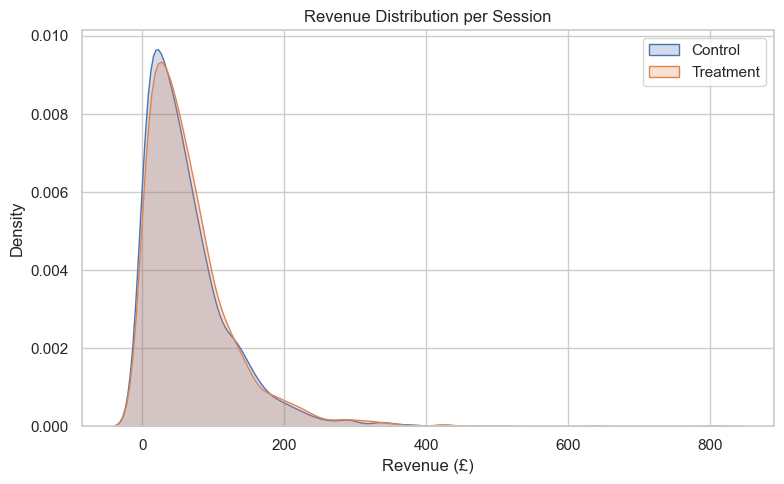

In [14]:
plt.figure(figsize=(8,5))
sns.kdeplot(ctrl_rev, label="Control", shade=True)
sns.kdeplot(trt_rev,  label="Treatment", shade=True)
plt.title("Revenue Distribution per Session")
plt.xlabel("Revenue (£)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "abtest_revenue_distribution.png")
plt.show()

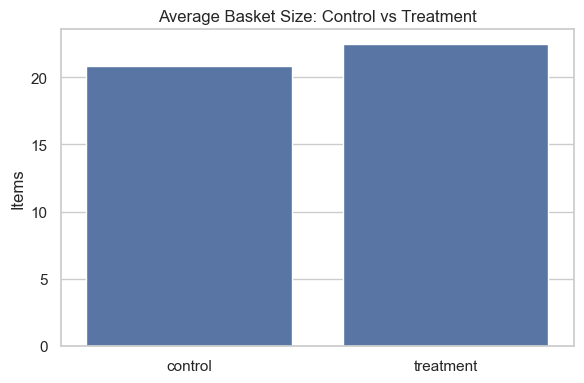

In [15]:
group_sizes = results.groupby("group")["basket_size_post"].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=group_sizes, x="group", y="basket_size_post")
plt.title("Average Basket Size: Control vs Treatment")
plt.xlabel("")
plt.ylabel("Items")
plt.tight_layout()
plt.savefig(FIG_DIR / "abtest_avg_basket_size.png")
plt.show()

In [16]:
report = {
    "N_control": summary["N_control"],
    "N_treatment": summary["N_treatment"],
    "Avg revenue (Control)": round(summary["avg_rev_control"], 2),
    "Avg revenue (Treatment)": round(summary["avg_rev_treatment"], 2),
    "Uplift (abs)": round(summary["avg_rev_uplift_abs"], 2),
    "Uplift (pct)": f"{summary['avg_rev_uplift_pct']*100:.2f}%",
    "95% CI uplift (abs)": (round(ci_lo,2), round(ci_hi,2)),
    "p-value (Welch t-test)": float(p_value),
    "Avg basket size (Control)": round(summary["avg_basket_size_control"], 3),
    "Avg basket size (Treatment)": round(summary["avg_basket_size_treatment"], 3),
    "Accept rate (Treatment)": f"{summary['accept_rate_treatment']*100:.1f}%",
    "Mean accepted items (Treatment)": round(summary["mean_accepted_items_treatment"], 3)
}
pd.Series(report)

N_control                                  2500
N_treatment                                2500
Avg revenue (Control)                     63.79
Avg revenue (Treatment)                   66.82
Uplift (abs)                               3.03
Uplift (pct)                              4.75%
95% CI uplift (abs)                (-0.38, 6.6)
p-value (Welch t-test)                 0.094397
Avg basket size (Control)                 20.82
Avg basket size (Treatment)              22.444
Accept rate (Treatment)                   83.8%
Mean accepted items (Treatment)           1.576
dtype: object

In [17]:
results.to_parquet(DATA_PROCESSED / "abtest_sessions.parquet", index=False)
results.to_csv(DATA_PROCESSED / "abtest_sessions.csv", index=False)

# summary + tests
out = dict(summary)
out.update({
    "ci_uplift_abs_lo": ci_lo,
    "ci_uplift_abs_hi": ci_hi,
    "t_test_p_value": float(p_value)
})
pd.Series(out).to_json(DATA_PROCESSED / "abtest_summary.json")